# Nearest Neighbour Analysis


One commonly used GIS task is to be able to find the nearest neighbour for an object or a set of objects. For instance, you might have a single Point object
representing your home location, and then another set of locations representing e.g. public transport stops. Then, quite typical question is *"which of the stops is closest one to my home?"*
This is a typical nearest neighbour analysis, where the aim is to find the closest geometry to another geometry.

In Python this kind of analysis can be done with shapely function called ``nearest_points()`` that [returns a tuple of the nearest points in the input geometries](https://shapely.readthedocs.io/en/latest/manual.html#shapely.ops.nearest_points).

## Nearest point using Shapely


Let's start by testing how we can find the nearest Point using the ``nearest_points()`` function of Shapely.

- Let's create an origin Point and a few destination Points and find out the closest destination:




In [1]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# Origin point
orig = Point(1, 1.67)

# Destination points
dest1 = Point(0, 1.45)
dest2 =Point(2, 2)
dest3 = Point(0, 2.5)

To be able to find out the closest destination point from the origin, we need to create a MultiPoint object from the destination points.

In [2]:
destinations = MultiPoint([dest1, dest2, dest3])
print(destinations)

MULTIPOINT (0 1.45, 2 2, 0 2.5)


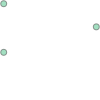

In [3]:
destinations

Okey, now we can see that all the destination points are represented as a single MultiPoint object.

- Now we can find out the nearest destination point by using ``nearest_points()`` function:


In [4]:
nearest_geoms = nearest_points(orig, destinations)

- We can check the data type of this object and confirm that the ``nearest_points()`` function returns a tuple of nearest points:

In [5]:
type(nearest_geoms)

tuple

 - let's check the contents of this tuple:

In [6]:
print(nearest_geoms)

(<shapely.geometry.point.Point object at 0x000001EA831F87B8>, <shapely.geometry.point.Point object at 0x000001EA831F8710>)


In [7]:
print(nearest_geoms[0])

POINT (1 1.67)


In [8]:
print(nearest_geoms[1])

POINT (0 1.45)


In the tuple, the first item (at index 0) is the geometry of our origin point and the second item (at index 1) is the actual nearest geometry from the destination points. Hence, the closest destination point seems to be the one located at coordinates (0, 1.45).

This is the basic logic how we can find the nearest point from a set of points.

## Nearest points using Geopandas

Let's then see how it is possible to find nearest points from a set of origin points to a set of destination points using GeoDataFrames. Here, we will use the ``PKS_suuralueet.kml`` district data, and the ``addresses.shp`` address points from previous sections. 



**Our goal in this tutorial is to find out the closest address to the centroid of each district.**

- Let's first read in the data and check their structure:

In [9]:
# Import geopandas
import geopandas as gpd

In [10]:
# Define filepaths
fp1 = "data/PKS_suuralue.kml"
fp2 = "data/addresses.shp"

In [11]:
# Enable KML driver
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [12]:
# Read in data with geopandas
df1 = gpd.read_file(fp1, driver='KML')
df2 = gpd.read_file(fp2)

In [13]:
# District polygons:
df1.head()

,Name,Description,geometry
0,Suur-Espoonlahti,,POLYGON Z ((24.775059677807 60.1090604462157 0...
1,Suur-Kauklahti,,POLYGON Z ((24.6157775254076 60.1725681273527 ...
2,Vanha-Espoo,,POLYGON Z ((24.6757633262026 60.2120070032819 ...
3,Pohjois-Espoo,,POLYGON Z ((24.767921197401 60.2691954732391 0...
4,Suur-Matinkylä,,POLYGON Z ((24.7536131356802 60.1663051341717 ...


In [14]:
# Address points:
df2.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.9155624 60.1632015)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.9316914 60.1690222)
2,"Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.9416849 60.1699637)
3,"Hermannin rantatie, Kyläsaari, Hermanni, Helsi...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.9719335 60.1969965)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.9216003 60.1566475)


- Furthermore, let's calculate the centroids for each district area:

In [15]:
df1['centroid'] = df1.centroid
df1.head()

,Name,Description,geometry,centroid
0,Suur-Espoonlahti,,POLYGON Z ((24.775059677807 60.1090604462157 0...,POINT (24.76754037242762 60.0440879200116)
1,Suur-Kauklahti,,POLYGON Z ((24.6157775254076 60.1725681273527 ...,POINT (24.57415010885406 60.19764302289445)
2,Vanha-Espoo,,POLYGON Z ((24.6757633262026 60.2120070032819 ...,POINT (24.60400724339237 60.25253297356344)
3,Pohjois-Espoo,,POLYGON Z ((24.767921197401 60.2691954732391 0...,POINT (24.68682879841453 60.30649462398335)
4,Suur-Matinkylä,,POLYGON Z ((24.7536131356802 60.1663051341717 ...,POINT (24.76063843560942 60.15018263640097)


SO, for each row of data in the disctricts -table, we want to figure out the nearest address point and fetch some attributes related to that point. In other words, we want to apply the Shapely `nearest_points`function so that we compare each polygon centroid to all address points, and based on this information access correct attribute information from the address table. 

For doing this, we can create a function that we will apply on the polygon GeoDataFrame:

In [23]:
def get_nearest_values(row, other_gdf, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].get_values()[0]
    
    return nearest_value

By default, this function returns the geometry of the nearest point for each row. It is also possible to fetch information from other columns by changing the `value_column` parameter.

The function creates a MultiPoint object from `other_gdf` geometry column (in our case, the address points) and further passes this MultiPoint object to Shapely's `nearest_points` function. 

Here, we are using a method for creating an union of all input geometries called `unary_union`. 

- Let's check how unary union works by applying it to the address points GeoDataFrame:

In [24]:
unary_union = df2.unary_union
print(unary_union)

MULTIPOINT (24.8608434 60.2240225, 24.86128 60.2484905, 24.8710287 60.222498, 24.8769977 60.2397435, 24.8842071 60.2305, 24.8941806817097 60.21721545, 24.9155624 60.1632015, 24.9212065 60.1587845, 24.9216003 60.1566475, 24.9252037 60.1648863, 24.9316914 60.1690222, 24.9331155798105 60.1690911, 24.9338755 60.1995271, 24.9416849 60.1699637, 24.9422931 60.1711382, 24.9470863 60.1719054, 24.9480051 60.2217879, 24.9495338 60.1794339, 24.961156 60.1879465, 24.9656577 60.2298169, 24.9719335 60.1969965, 24.9936217 60.2436491, 25.0068082 60.1887169, 25.0130341 60.2513441, 25.0204879 60.243423, 25.026632061488 60.1944775, 25.0291169 60.2636285, 25.0331561080774 60.2777903, 25.0747841 60.2253109, 25.0783462 60.209819, 25.0817387723606 60.23521665, 25.1069663 60.2391463, 25.1109579 60.2216552, 25.1368632 60.2070291)


Okey now we are ready to use our function and find closest address point for each polygon centroid.
 - Try first applying the function without any additional modifications: 

In [26]:
df1["nearest_loc"] = df1.apply(get_nearest_values, other_gdf=df2, point_column="centroid", axis=1)

0           POINT (24.9155624 60.1632015)
1           POINT (24.8608434 60.2240225)
2             POINT (24.86128 60.2484905)
3             POINT (24.86128 60.2484905)
4           POINT (24.8608434 60.2240225)
5           POINT (24.8608434 60.2240225)
6           POINT (24.8608434 60.2240225)
7           POINT (24.8608434 60.2240225)
8             POINT (24.86128 60.2484905)
9             POINT (24.86128 60.2484905)
10          POINT (24.9216003 60.1566475)
11          POINT (25.0068082 60.1887169)
12           POINT (24.961156 60.1879465)
13           POINT (24.8710287 60.222498)
14          POINT (24.9480051 60.2217879)
15           POINT (25.0204879 60.243423)
16          POINT (24.9656577 60.2298169)
17    POINT (25.0331561080774 60.2777903)
18    POINT (25.0331561080774 60.2777903)
19          POINT (25.1368632 60.2070291)
20          POINT (25.1368632 60.2070291)
21          POINT (25.1069663 60.2391463)
22    POINT (25.0331561080774 60.2777903)
dtype: object

- Finally, we can specify that we want the `id` -column for each point, and store the output in a new column `"nearest_loc"`:

In [28]:
df1["nearest_loc"] = df1.apply(get_nearest_values, other_gdf=df2, point_column="centroid", value_column="id", axis=1)

In [29]:
df1.head()

,Name,Description,geometry,centroid,nearest_loc
0,Suur-Espoonlahti,,POLYGON Z ((24.775059677807 60.1090604462157 0...,POINT (24.76754037242762 60.0440879200116),1000
1,Suur-Kauklahti,,POLYGON Z ((24.6157775254076 60.1725681273527 ...,POINT (24.57415010885406 60.19764302289445),1020
2,Vanha-Espoo,,POLYGON Z ((24.6757633262026 60.2120070032819 ...,POINT (24.60400724339237 60.25253297356344),1017
3,Pohjois-Espoo,,POLYGON Z ((24.767921197401 60.2691954732391 0...,POINT (24.68682879841453 60.30649462398335),1017
4,Suur-Matinkylä,,POLYGON Z ((24.7536131356802 60.1663051341717 ...,POINT (24.76063843560942 60.15018263640097),1020


That's it! Now we found the closest point for each centroid and got the ``id`` value from our addresses into the ``df1`` GeoDataFrame.
